# Import Libraries

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import numpy as np
import random
import time
import matplotlib

# Initial Conditions

In [4]:
K = 0.5 #Carrying Capacity Density
r = 0.8
mp = 0 #mutation probability

def makeLattice(N, M, tumor_size=20, cluster_spread=1):
    lat = np.zeros((N, M), dtype=int)
    
    start_x = N // 2 #starting point
    start_y = M // 2
    tumor_cells = [(start_x, start_y)]
    
    while len(tumor_cells) < tumor_size:
        #Randomly choose one of the current tumor cells to "expand"
        current_cell = tumor_cells[random.choice(range(len(tumor_cells)))]
        cx, cy = current_cell
        
        # Try to spread cancer cells in a random direction around the current cell
        for dx in range(-cluster_spread, cluster_spread + 1):
            for dy in range(-cluster_spread, cluster_spread + 1):
                if random.random() < 0.5: 
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < N and 0 <= ny < M and lat[nx, ny] == 0:
                        lat[nx, ny] = 1
                        tumor_cells.append((nx, ny))
    
    return lat

# Neighborhood

In [6]:
def getVN(i, j, lattice):
    N, M = lattice.shape
    neighbors = np.array([[0, -1], [0, 1], [-1, 0], [1, 0]])

    VN = []
    for di, dj in neighbors:
        ni, nj = i + di, j + dj 
        if 0 <= ni < N and 0 <= nj < M:
            VN.append(lattice[ni, nj])
    return VN

# Helper Functions

In [8]:
#Function to count the number of cancer cells in the neighborhood
def checkNeighbors(i, j, lattice):
    VN = getVN(i, j, lattice)
    cancers = sum(1 for neighbor in VN if neighbor == 1)
    return cancers
    
#Function to get the total number of cancer cells in the lattice
def countCancerCells(lattice):
    return np.sum(lattice == 1)
    
#Function to plot the lattice
def plotlattice(lattice, ax):
    N, M = lattice.shape
    cmap = ListedColormap(['white', 'cornflowerblue'])
    im = ax.imshow(lattice, cmap=cmap, interpolation='nearest', aspect='equal')
    ax.set_title('Lattice')
    #ax.grid(True, which='minor', axis='both', color='black', linestyle='-', linewidth=1)
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)  
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_xticks(np.arange(0, M, 1))
    ax.set_yticks(np.arange(0, N, 1)) 
    ax.set_xticklabels(np.arange(0, M, 1)) 
    ax.set_yticklabels(np.arange(0, N, 1))  
    ax.tick_params(which='minor', size=0)
    return im

def logisticGrowth(t, K, N0, r):
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

def fitLogisticGrowth(tumorSizes, ax2):
    t = np.arange(len(tumorSizes))
    guess = [max(tumorSizes), tumorSizes[0], 0.1]
    popt, _ = curve_fit(logisticGrowth, t, tumorSizes, p0=guess, bounds=(0, [np.inf, np.inf, 1]))
    
    K_fit, N0_fit, r_fit = popt
    print(f"Fitted parameters:")
    print(f"Carrying Capacity (K): {K_fit}")
    print(f"Initial tumor size (N0): {N0_fit}")
    print(f"Growth rate (r): {r_fit}")
    
    t_fit = np.linspace(0, len(tumorSizes) - 1, 100) 
    ax2.plot(t_fit, logisticGrowth(t_fit, *popt), label="Logistic Growth Fit", color='red', linestyle='--')
    ax2.legend()

    return pop
    
def getGrowthProbability(lattice):
    N, M = lattice.shape
    numCancers = np.sum(lattice == 1)
    density = numCancers / (N * M) 
    gp = r * density * (1 - density / K)
    return max(0, min(gp, 1))

# Rule

In [10]:
def rule(lattice):
    N, M = lattice.shape
    newLat = lattice.copy()
    gp = getGrowthProbability(lattice)
    
    for i in range(N):
        for j in range(M):
            tumorNeighbors = checkNeighbors(i, j, lattice)
            #ap = max(0.05, 0.01 * tumorNeighbors)  # Higher apoptosis for crowded cells

            if lattice[i,j] == 0 and tumorNeighbors > 0 and np.random.rand() < gp:
                newLat[i,j] = 1
            else:
                if np.random.rand() < 0: # Apoptosis rule
                    newLat[i, j] = 0
    return newLat

# Run Simulation

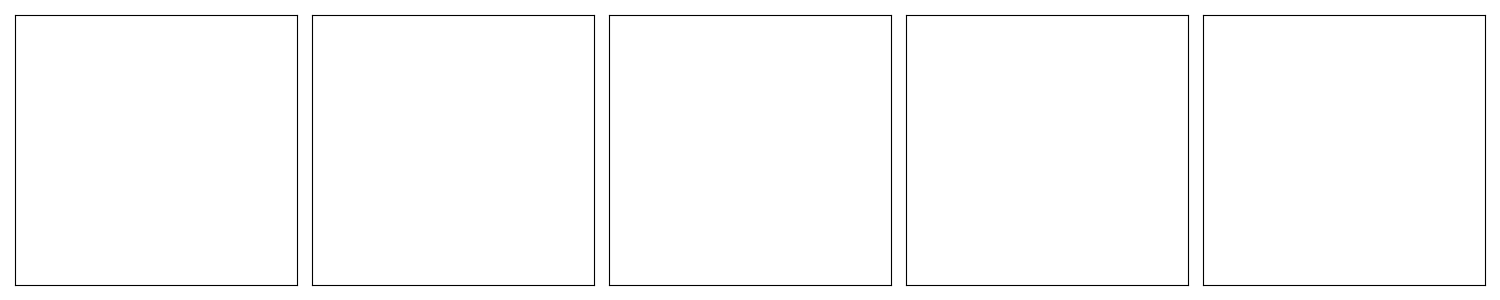

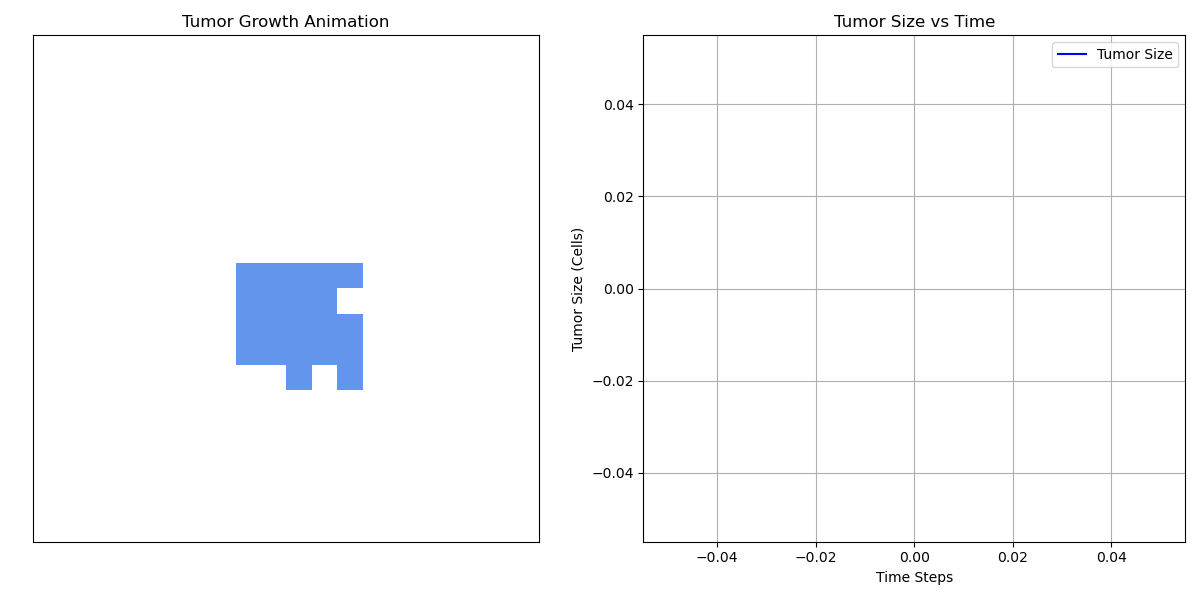

In [12]:
def run(lattice, steps, scale=2, snapshotSteps=None):
    N, M = lattice.shape
    
    if snapshotSteps is None:
        snapshotSteps = [0, steps//4, steps//2, 3*steps//4, steps-1]
    
    # Figure 1: Tumor growth animation and tumor size vs. time plot
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    # Animation plot (first subplot)
    im = plotlattice(lattice, ax1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Tumor Growth Animation")

    # Tumor size vs. time plot (second subplot)
    tumorSizes = [countCancerCells(lattice)]
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Tumor Size (Cells)')
    ax2.set_title('Tumor Size vs Time')
    ax2.grid(True)
    tumorSizeLine, = ax2.plot([], [], label="Tumor Size", color='blue')
    ax2.legend()

    # Figure 2: 5 snapshot plots
    fig2, snapshotAxes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns
    for ax in snapshotAxes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Update the tumor size line plot
    def updateLinePlot():
        tumorSize = countCancerCells(lattice)
        tumorSizes.append(tumorSize)
        tumorSizeLine.set_data(range(len(tumorSizes)), tumorSizes)
        ax2.relim()  # Recalculate the axis limits
        ax2.autoscale_view()  # Auto-scale the plot

    def update(frame):
        nonlocal lattice
        lattice = rule(lattice) 
        im.set_array(lattice)  
        updateLinePlot()  

        if frame in snapshotSteps:
            snapshotIndex = snapshotSteps.index(frame)
            snapshotAxes[snapshotIndex].imshow(lattice, cmap=ListedColormap(['white', 'cornflowerblue']), interpolation='nearest')
            snapshotAxes[snapshotIndex].set_title(f"Step: {frame}", fontsize = 10)

        if frame >= steps - 1:
            ani.event_source.stop()
            print(f"Stopping animation due to max time steps.")
        
        return [im, tumorSizeLine]

    # Create the animation
    ani = FuncAnimation(fig1, update, frames=range(steps), interval=100, blit=True)

    plt.tight_layout()
    fig1.tight_layout()
    plt.show()

    return tumorSizes

N = 20  #rows
M = 20  #columns
steps = 70  #simulation steps

#Run:
test = makeLattice(N, M)
tumorSizes = run(test, steps)

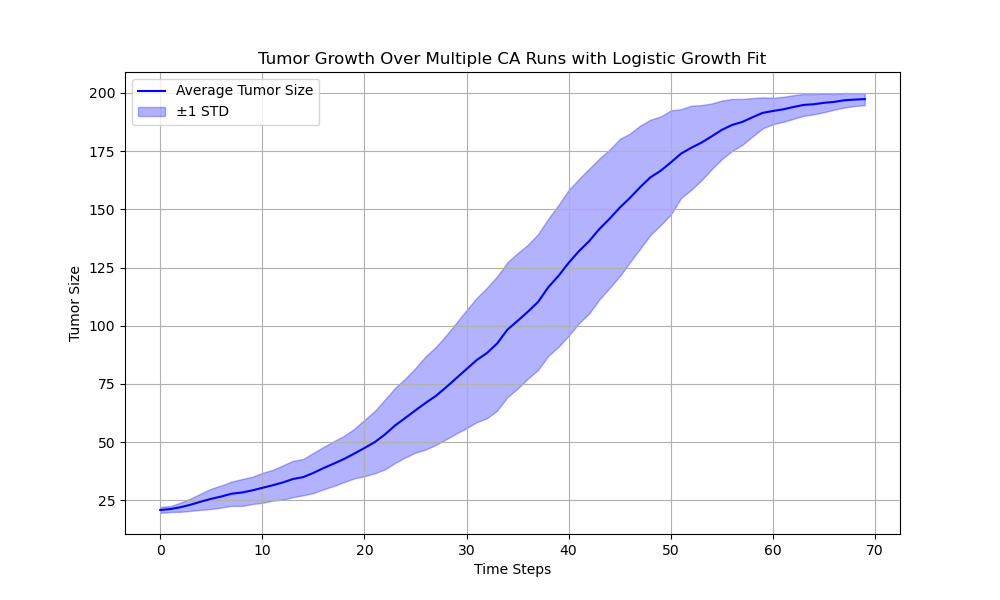

In [13]:
def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def runMultipleSims(N, M, steps, runs=10):
    tumorSizeAll = np.zeros((runs, steps))  #Array to store tumor sizes for all runs

    for run in range(runs):
        lattice = makeLattice(N, M) 
        
        for t in range(steps):
            lattice = rule(lattice)  
            tumorSizeAll[run, t] = countCancerCells(lattice) 

    return tumorSizeAll

N = 20 
M = 20 
steps = 70 
runs = 10 

tumorSizes = runMultipleSims(N, M, steps, runs)

meanTumorSizeAll = tumorSizes.mean(axis=0) 
STDTumorSizeAll = tumorSizes.std(axis=0) 

plt.figure(figsize=(10, 6))
plt.plot(meanTumorSizeAll, label='Average Tumor Size', color='blue')
plt.fill_between(range(steps), 
                 meanTumorSizeAll - STDTumorSizeAll, 
                 meanTumorSizeAll + STDTumorSizeAll, 
                 color='blue', alpha=0.3, label='±1 STD') 

plt.xlabel('Time Steps')
plt.ylabel('Tumor Size')
plt.title('Tumor Growth Over Multiple CA Runs with Logistic Growth Fit')
plt.legend()
plt.grid(True)
plt.show()

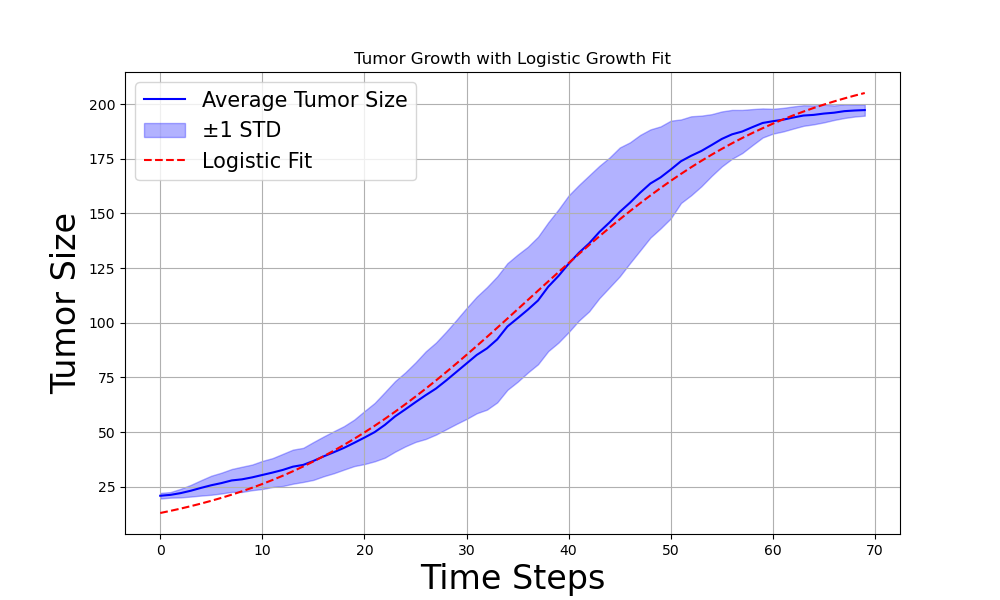

Fitted parameters: K=221.3866648277334, r=0.07691991006763428, t0=36.06299099732532


In [14]:
initial_guess = [300, 0.1, steps / 2]
params, covariance = curve_fit(logistic_growth, np.arange(steps), meanTumorSizeAll, p0=initial_guess, maxfev=5000)

K_fit, r_fit, t0_fit = params

fitted_curve = logistic_growth(np.arange(steps), K_fit, r_fit, t0_fit)

plt.figure(figsize=(10, 6))
plt.plot(meanTumorSizeAll, label='Average Tumor Size', color='blue')
plt.fill_between(range(steps), 
                 meanTumorSizeAll - STDTumorSizeAll, 
                 meanTumorSizeAll + STDTumorSizeAll, 
                 color='blue', alpha=0.3, label='±1 STD')  # Shaded area for standard deviation

plt.plot(np.arange(steps), fitted_curve, label='Logistic Fit', color='red', linestyle='--')

plt.xlabel('Time Steps', fontsize = 24)
plt.ylabel('Tumor Size',  fontsize = 24)
plt.title('Tumor Growth with Logistic Growth Fit', fontsize = 12)
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

print(f"Fitted parameters: K={K_fit}, r={r_fit}, t0={t0_fit}")


In [15]:
# Calculate MAE
mae = np.mean(np.abs(meanTumorSizeAll - fitted_curve))

print(f"MAE: {mae}")

overall_std = np.std(tumorSizes.flatten())
print(f"Overall standard deviation of tumor sizes: {overall_std}")

rmse = np.sqrt(np.mean((meanTumorSizeAll - fitted_curve) ** 2))

print(f"RMSE: {rmse}")

MAE: 3.7180122747757163
Overall standard deviation of tumor sizes: 67.14368236574944
RMSE: 4.246570643391884
